In [1]:
!pip install --upgrade keras_applications==1.0.6 keras==2.2.4

    100% |████████████████████████████████| 51kB 31.8MB/s ta 0:00:01
Requirement already up-to-date: keras==2.2.4 in /home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/site-packages
    100% |████████████████████████████████| 4.0MB 104.6MB/s ta 0:00:01�██████████████▊             | 2.3MB 85.8MB/s eta 0:00:01
    100% |████████████████████████████████| 13.4MB 75.3MB/s ta 0:00:011████████████▎    | 11.4MB 103.2MB/s eta 0:00:01
    100% |████████████████████████████████| 25.9MB 106.8MB/s ta 0:00:01       | 2.5MB 80.6MB/s eta 0:00:01██████████▎                     | 8.3MB 96.8MB/s eta 0:00:01��█▏               | 13.1MB 105.3MB/s eta 0:00:01███████████████▎         | 18.0MB 101.9MB/s eta 0:00:01
    100% |████████████████████████████████| 51kB 97.3MB/s ta 0:00:01
    100% |████████████████████████████████| 645kB 116.2MB/s ta 0:00:01
  Found existing installation: numpy 1.16.2
    Uninstalling numpy-1.16.2:
      Successfully uninstalled numpy-1.16.2
  Found existing installation: 

In [2]:
import os
if os.path.exists('./data') == False:
    from modelarts.session import Session
    session = Session()
    
    if session.region_name == 'eu-west-0':
        bucket_path="modelarts-labs/dataset-dog-and-cat-25000/zip-data/dog_and_cat_25000.tar.gz"
    elif session.region_name == 'cn-north-4':
        bucket_path="modelarts-labs-bj4/end2end/image_recognition/dog_and_cat_25000.tar.gz"
    else:
        print("Please swith region to Paris")
        
    session.download_data(
        bucket_path=bucket_path,
        path="./dog_and_cat_25000.tar.gz")

    # 使用tar命令解压资源包
    !tar xf ./dog_and_cat_25000.tar.gz

    # 清理压缩包
    !rm -f ./dog_and_cat_25000.tar.gz

Successfully download file modelarts-labs/dataset-dog-and-cat-25000/zip-data/dog_and_cat_25000.tar.gz from OBS to local ./dog_and_cat_25000.tar.gz


In [3]:
!mkdir model

In [4]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
import numpy as np

from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.models import load_model

from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.
/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16",

In [5]:
import os
from PIL import Image
def load_data():
    dirname = "./data"
    path = "./data"

    num_train_samples = 25000

    x_train = np.empty((num_train_samples, 224,224,3), dtype='uint8')
    y_train = np.empty((num_train_samples,1), dtype='uint8')
    index = 0
    for file in os.listdir("./data"):
        image = Image.open(os.path.join(dirname,file)).resize((224,224))
        image = np.array(image)
        x_train[index,:,:,:] = image

        if "cat" in file:
            y_train[index,0] =1
        elif "dog" in file:
            y_train[index,0] =0

        index += 1
    return (x_train, y_train)

In [6]:
(x_train, y_train) = load_data()

In [7]:
print(x_train.shape)
print(y_train.shape)

(25000, 224, 224, 3)
(25000, 1)


In [8]:
from keras.utils import np_utils
def process_data(x_train,y_train):
    x_train = x_train.astype(np.float32)
    x_train /= 255
    n_classes = 2
    y_train = np_utils.to_categorical(y_train, n_classes)
    return x_train,y_train

In [9]:
x_train,y_train= process_data(x_train,y_train)
print(x_train.shape)
print(y_train.shape)

(25000, 224, 224, 3)
(25000, 2)


In [10]:
def build_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(2, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    print(type(model))
    return model

In [11]:
base_model = VGG16(weights=None, include_top=False)

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
model = build_model(base_model)
model.summary()

<class 'keras.engine.training.Model'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, No

In [13]:
import keras 
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [14]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
es = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=5, verbose=1, mode='auto')
cp = ModelCheckpoint(filepath="./model/ckp_vgg16_dog_and_cat.h5", monitor="val_acc", verbose=1, save_best_only=True, mode="auto", period=1)
lr = ReduceLROnPlateau(monitor="val_acc", factor=0.1, patience=3, verbose=1, mode="auto", min_lr=0)
callbacks = [es,cp,lr]

In [15]:
history = model.fit(x=x_train, 
                  y=y_train, 
                  batch_size=16, 
                  epochs=5, 
                  verbose=1, 
                  callbacks=callbacks, 
                  validation_split=0.25, 
                  shuffle=True, 
                  initial_epoch=0, 
                 )

Instructions for updating:
Use tf.cast instead.


Train on 18750 samples, validate on 6250 samples
Epoch 1/5
18750/18750 [==============================] - 125s 7ms/step - loss: 0.6637 - acc: 0.5947 - val_loss: 0.6614 - val_acc: 0.6125

Epoch 00001: val_acc improved from -inf to 0.61248, saving model to ./model/ckp_vgg16_dog_and_cat.h5
Epoch 2/5
18750/18750 [==============================] - 102s 5ms/step - loss: 0.5841 - acc: 0.6943 - val_loss: 0.5800 - val_acc: 0.6472

Epoch 00002: val_acc improved from 0.61248 to 0.64720, saving model to ./model/ckp_vgg16_dog_and_cat.h5
Epoch 3/5
18750/18750 [==============================] - 102s 5ms/step - loss: 0.4461 - acc: 0.7918 - val_loss: 0.4924 - val_acc: 0.7794

Epoch 00003: val_acc improved from 0.64720 to 0.77936, saving model to ./model/ckp_vgg16_dog_and_cat.h5
Epoch 4/5
18750/18750 [==============================] - 102s 5ms/step - loss: 0.3507 - acc: 0.8437 - val_loss: 0.3008 - val_acc: 0.8682

Epoch 00004: val_acc improved from 0.77936 to 0.86816, saving model to ./model/ckp_vgg16_d

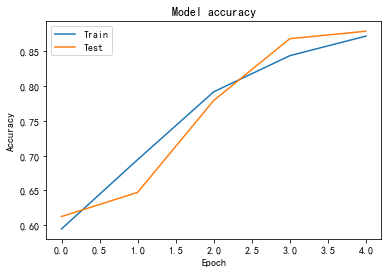

In [18]:
import matplotlib.pyplot as plt

# 绘制训练 & 验证的准确率值
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

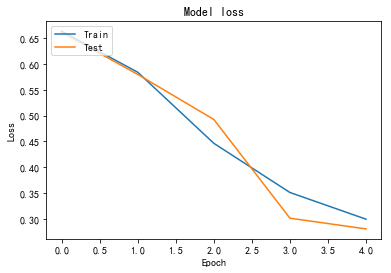

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [19]:
history_more_steps = model.fit(x=x_train, 
                  y=y_train, 
                  batch_size=16, 
                  epochs=5, 
                  verbose=1, 
                  callbacks=callbacks, 
                  validation_split=0.25, 
                  shuffle=True, 
                  initial_epoch=0, 
                 )

Train on 18750 samples, validate on 6250 samples
Epoch 1/5
18750/18750 [==============================] - 103s 6ms/step - loss: 0.2634 - acc: 0.8907 - val_loss: 0.2393 - val_acc: 0.9005

Epoch 00001: val_acc improved from 0.87888 to 0.90048, saving model to ./model/ckp_vgg16_dog_and_cat.h5
Epoch 2/5
18750/18750 [==============================] - 103s 6ms/step - loss: 0.2325 - acc: 0.9025 - val_loss: 0.2978 - val_acc: 0.8858

Epoch 00002: val_acc did not improve from 0.90048
Epoch 3/5
18750/18750 [==============================] - 103s 6ms/step - loss: 0.2046 - acc: 0.9172 - val_loss: 0.2008 - val_acc: 0.9219

Epoch 00003: val_acc improved from 0.90048 to 0.92192, saving model to ./model/ckp_vgg16_dog_and_cat.h5
Epoch 4/5
18750/18750 [==============================] - 103s 6ms/step - loss: 0.1863 - acc: 0.9254 - val_loss: 0.1917 - val_acc: 0.9214

Epoch 00004: val_acc did not improve from 0.92192
Epoch 5/5
18750/18750 [==============================] - 103s 6ms/step - loss: 0.1674 - acc

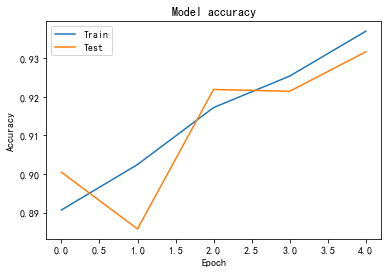

In [20]:
import matplotlib.pyplot as plt

# 绘制训练 & 验证的准确率值
plt.plot(history_more_steps.history['acc'])
plt.plot(history_more_steps.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

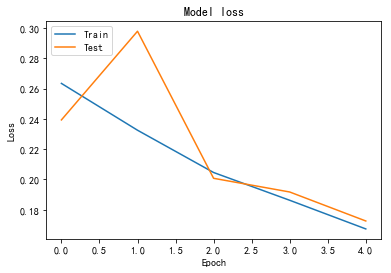

In [21]:
# 绘制训练 & 验证的损失值
plt.plot(history_more_steps.history['loss'])
plt.plot(history_more_steps.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [22]:
es = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=1, verbose=1, mode='auto')
cp = ModelCheckpoint(filepath="./model/ckp_vgg16_dog_and_cat.h5", monitor="val_acc", verbose=1, save_best_only=True, mode="auto", period=1)
lr = ReduceLROnPlateau(monitor="val_acc", factor=0.1, patience=3, verbose=1, mode="auto", min_lr=0)
callbacks = [es,cp,lr]

In [23]:
history_steps_15 = model.fit(x=x_train, 
                  y=y_train, 
                  batch_size=16, 
                  epochs=20, 
                  verbose=1, 
                  callbacks=callbacks, 
                  validation_split=0.25, 
                  shuffle=True, 
                  initial_epoch=0, 
                 )

Train on 18750 samples, validate on 6250 samples
Epoch 1/20
18750/18750 [==============================] - 103s 6ms/step - loss: 0.1588 - acc: 0.9393 - val_loss: 0.1752 - val_acc: 0.9256

Epoch 00001: val_acc improved from -inf to 0.92560, saving model to ./model/ckp_vgg16_dog_and_cat.h5
Epoch 2/20
18750/18750 [==============================] - 103s 6ms/step - loss: 0.1470 - acc: 0.9444 - val_loss: 0.1942 - val_acc: 0.9285

Epoch 00002: val_acc improved from 0.92560 to 0.92848, saving model to ./model/ckp_vgg16_dog_and_cat.h5
Epoch 3/20
18750/18750 [==============================] - 103s 6ms/step - loss: 0.1385 - acc: 0.9495 - val_loss: 0.1590 - val_acc: 0.9398

Epoch 00003: val_acc improved from 0.92848 to 0.93984, saving model to ./model/ckp_vgg16_dog_and_cat.h5
Epoch 4/20
18750/18750 [==============================] - 103s 6ms/step - loss: 0.1392 - acc: 0.9502 - val_loss: 0.1809 - val_acc: 0.9373

Epoch 00004: val_acc did not improve from 0.93984
Epoch 00004: early stopping


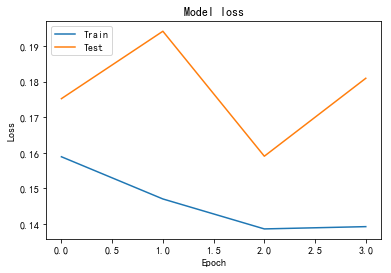

In [24]:

plt.plot(history_steps_15.history['loss'])
plt.plot(history_steps_15.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

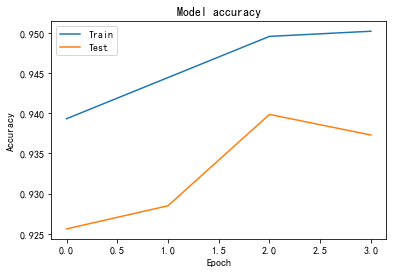

In [25]:
plt.plot(history_steps_15.history['acc'])
plt.plot(history_steps_15.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()